In [45]:
# Cell 1: Import Libraries
import numpy as np
import time
import random
import sys
import psutil
import math
from itertools import permutations
import os # Added for file creation example

print("Libraries imported successfully.")

Libraries imported successfully.


In [46]:
# Cell 2: Utility Functions

# Hàm đo lượng bộ nhớ sử dụng (Function to measure memory usage)
def get_memory_usage():
  """Returns the current memory usage of the process in MB."""
  process = psutil.Process()
  return process.memory_info().rss / (1024 * 1024)  # MB

# Hàm tính tổng độ dài của một hành trình (Function to calculate total tour distance)
def calculate_tour_distance(tour, dist_matrix):
  """Calculates the total distance of a given tour based on the distance matrix."""
  distance = 0
  n = len(tour)
  for i in range(n):
    # Calculate distance from current city to the next city in the tour
    # Use modulo n to wrap around from the last city to the first
    distance += dist_matrix[tour[i]][tour[(i + 1) % n]]
  return distance

print("Utility functions defined: get_memory_usage, calculate_tour_distance")

Utility functions defined: get_memory_usage, calculate_tour_distance


In [47]:
# Cell 3: TSP Data Reading Function

# Đọc dữ liệu từ file TSP (Read data from TSP file)
def read_tsp_file(filename):
  """
  Reads a TSP file with EDGE_WEIGHT_FORMAT: LOWER_DIAG_ROW.
  Returns a NumPy distance matrix.
  """
  with open(filename, 'r') as file:
    lines = file.readlines()

  dimension = 0
  edge_weight_format = ""
  edge_weights = []
  reading_weights = False

  for line in lines:
    line = line.strip()
    if line.startswith("DIMENSION"):
      dimension = int(line.split(":")[1].strip())
    elif line.startswith("EDGE_WEIGHT_FORMAT"):
      edge_weight_format = line.split(":")[1].strip()
      if edge_weight_format != "LOWER_DIAG_ROW":
            raise ValueError(f"Unsupported EDGE_WEIGHT_FORMAT: {edge_weight_format}. Only LOWER_DIAG_ROW is supported.")
    elif line.startswith("EDGE_WEIGHT_SECTION"):
      reading_weights = True
      continue
    elif line == "EOF" or line.startswith("DISPLAY_DATA_SECTION"): # Handle potential end markers
        reading_weights = False
        break # Stop reading after weight section

    if reading_weights:
      # Split line and handle potential empty strings from multiple spaces
      weights_in_line = [float(x) for x in line.split() if x]
      edge_weights.extend(weights_in_line)

  if dimension == 0:
      raise ValueError("DIMENSION not found in TSP file.")
  if not edge_weights:
      raise ValueError("EDGE_WEIGHT_SECTION not found or empty.")

  # Khởi tạo ma trận khoảng cách (Initialize distance matrix)
  dist_matrix = np.zeros((dimension, dimension))

  # Populate the distance matrix from LOWER_DIAG_ROW format
  if edge_weight_format == "LOWER_DIAG_ROW":
    index = 0
    for i in range(dimension):
      for j in range(i + 1):
        if index >= len(edge_weights):
             raise ValueError(f"Not enough weights provided in EDGE_WEIGHT_SECTION. Expected more weights for row {i}, column {j}.")
        dist_matrix[i][j] = edge_weights[index]
        if i != j:  # If not on the diagonal, assign the symmetric value
          dist_matrix[j][i] = edge_weights[index]
        index += 1
    # Check if the correct number of weights were read
    expected_weights = dimension * (dimension + 1) // 2
    if index != expected_weights:
        print(f"Warning: Read {index} weights, expected {expected_weights} for LOWER_DIAG_ROW format with dimension {dimension}. Check TSP file format.")

  else:
      # This case is already handled by the check above, but kept for clarity
      print(f"Warning: EDGE_WEIGHT_FORMAT is {edge_weight_format}, but only LOWER_DIAG_ROW logic is implemented.")


  return dist_matrix

print("TSP file reading function defined: read_tsp_file")

TSP file reading function defined: read_tsp_file


In [48]:
# Cell 4: Algorithm 1 - Nearest Neighbor

# 1. Thuật toán tham lam (Nearest Neighbor)
def nearest_neighbor(dist_matrix):
  """
  Finds a TSP tour using the Nearest Neighbor greedy algorithm.
  Starts at city 0 and repeatedly visits the closest unvisited city.
  """
  n = len(dist_matrix)
  start_time = time.time()
  start_memory = get_memory_usage()

  # Bắt đầu từ thành phố 0 (Start from city 0)
  current_city = 0
  unvisited = set(range(1, n))
  tour = [current_city]

  # Liên tục chọn thành phố gần nhất chưa thăm (Continuously select the nearest unvisited city)
  while unvisited:
    # Find the nearest city among the unvisited ones
    next_city = min(unvisited, key=lambda city: dist_matrix[current_city][city])
    tour.append(next_city)
    unvisited.remove(next_city)
    current_city = next_city

  distance = calculate_tour_distance(tour, dist_matrix)
  end_time = time.time()
  # Measure memory difference carefully
  end_memory = get_memory_usage()
  # Ensure memory calculation is non-negative
  memory_used = max(0, end_memory - start_memory)


  return {
    "tour": tour,
    "distance": distance,
    "time": end_time - start_time,
    "memory": memory_used # Report the difference
  }

print("Algorithm 1 defined: nearest_neighbor")

Algorithm 1 defined: nearest_neighbor


In [49]:
# Cell 5: Algorithm 2 - Brute Force

# 2. Thuật toán duyệt cạn (Brute Force)
def brute_force(dist_matrix):
  """
  Finds the optimal TSP tour by checking all possible permutations.
  Extremely slow and memory-intensive, only feasible for very small N.
  """
  n = len(dist_matrix)
  start_time = time.time()
  start_memory = get_memory_usage()

  # Giới hạn để tránh tràn bộ nhớ và thời gian chạy quá lâu
  # Limit to avoid excessive memory usage and runtime
  # Factorial(n-1) grows very fast. (11-1)! = 3,628,800. (12-1)! = 39,916,800
  if n > 11:
    print(f"Brute Force skipped for n={n} (too large).")
    return {"tour": [], "distance": float('inf'), "time": 0, "memory": 0, "skipped": True}

  # Thành phố đầu tiên luôn là 0, chỉ hoán vị các thành phố còn lại
  # First city is fixed (e.g., 0), only permute the remaining cities
  cities = list(range(1, n))
  best_distance = float('inf')
  best_tour = None

  # Generate all permutations of cities 1 to n-1
  for perm in permutations(cities):
    tour = [0] + list(perm) # Prepend the starting city 0
    distance = calculate_tour_distance(tour, dist_matrix)
    if distance < best_distance:
      best_distance = distance
      best_tour = tour

  end_time = time.time()
  end_memory = get_memory_usage()
  memory_used = max(0, end_memory - start_memory)


  return {
    "tour": best_tour,
    "distance": best_distance,
    "time": end_time - start_time,
    "memory": memory_used,
    "skipped": False
  }

print("Algorithm 2 defined: brute_force")

Algorithm 2 defined: brute_force


In [50]:
# Cell 6: Algorithm 3 - 2-Opt (Approximation)

# 3. Thuật toán xấp xỉ (2-opt)
def two_opt(dist_matrix, initial_tour=None):
    """
    Improves an existing TSP tour using the 2-opt heuristic.
    Repeatedly swaps pairs of edges if it reduces the total distance.
    """
    n = len(dist_matrix)
    start_time = time.time()
    start_memory = get_memory_usage()

    # Bắt đầu với một tour ban đầu (Start with an initial tour)
    # If no initial tour provided, start with 0, 1, 2, ..., n-1
    if initial_tour is None:
        tour = list(range(n))
    else:
        tour = initial_tour[:] # Make a copy

    best_distance = calculate_tour_distance(tour, dist_matrix)

    improved = True
    while improved:
        improved = False
        # Iterate through all possible pairs of non-adjacent edges to swap
        for i in range(n - 1): # Use n-1 to correctly handle edges (i, i+1) and (j, j+1) mod n
            for j in range(i + 1, n):
                # Indices for the edges (i, i+1) and (j, j+1)
                # Ensure wrap-around using modulo n
                city1_idx, city2_idx = i, (i + 1) % n
                city3_idx, city4_idx = j, (j + 1) % n

                # Check if swapping edges reduces distance
                # Current distance: dist(i, i+1) + dist(j, j+1)
                current_edge_dist = dist_matrix[tour[city1_idx]][tour[city2_idx]] + dist_matrix[tour[city3_idx]][tour[city4_idx]]
                # New distance: dist(i, j) + dist(i+1, j+1)
                new_edge_dist = dist_matrix[tour[city1_idx]][tour[city3_idx]] + dist_matrix[tour[city2_idx]][tour[city4_idx]]

                if new_edge_dist < current_edge_dist:
                    # Perform the 2-opt swap (reverse the segment between i+1 and j)
                    # Create the new tour by reversing the segment
                    new_tour = tour[:city2_idx] + tour[city2_idx:city3_idx+1][::-1] + tour[city3_idx+1:]

                    # Recalculate to be absolutely sure, though delta calculation is faster
                    # new_distance = calculate_tour_distance(new_tour, dist_matrix) # Can use delta for speedup

                    tour = new_tour # Update the tour
                    best_distance = calculate_tour_distance(tour, dist_matrix) # Recalculate the total distance
                    improved = True
                    # Go back to the outer loop to restart checks after an improvement
                    break # Break inner loop (j)
            if improved:
                break # Break outer loop (i) if improvement was found


    end_time = time.time()
    end_memory = get_memory_usage()
    memory_used = max(0, end_memory - start_memory)


    return {
        "tour": tour,
        "distance": best_distance,
        "time": end_time - start_time,
        "memory": memory_used
    }

print("Algorithm 3 defined: two_opt")

Algorithm 3 defined: two_opt


In [51]:
# Cell 7: Algorithm 4 - Ant Colony Optimization (ACO)

# 4. Thuật toán bầy kiến (Ant Colony Optimization)
def ant_colony_optimization(dist_matrix, n_ants=10, n_iterations=100, alpha=1.0, beta=2.0, evaporation_rate=0.5, Q=100):
  """
  Finds a TSP tour using the Ant Colony Optimization metaheuristic.
  Simulates ants laying pheromone trails, influencing subsequent ants.
  """
  n = len(dist_matrix)
  start_time = time.time()
  start_memory = get_memory_usage()

  # Khởi tạo ma trận pheromone (Initialize pheromone matrix)
  # Adding a small epsilon to avoid zero distances/pheromones causing issues
  epsilon = 1e-10
  pheromone = np.ones((n, n))
  visibility = 1.0 / (dist_matrix + epsilon) # Heuristic information (inverse distance)

  best_tour = None
  best_distance = float('inf')

  for iteration in range(n_iterations):
    all_tours = []
    all_distances = []

    # Mỗi con kiến tạo một hành trình (Each ant builds a tour)
    for ant in range(n_ants):
      tour = [random.randint(0, n - 1)]  # Start at a random city
      unvisited = set(range(n))
      unvisited.remove(tour[0])

      # Xây dựng hành trình (Build the tour)
      while unvisited:
        current = tour[-1]
        probabilities = []
        total_prob = 0.0

        # Calculate probabilities for moving to each unvisited city
        for city in unvisited:
          tau = pheromone[current][city] ** alpha
          eta = visibility[current][city] ** beta
          prob = tau * eta
          probabilities.append((city, prob))
          total_prob += prob

        # Select the next city based on probabilities
        if total_prob == 0: # Handle cases where all options might have zero probability (e.g., alpha/beta interaction)
             next_city = random.choice(list(unvisited)) # Fallback: choose randomly
        else:
            rand_val = random.uniform(0, total_prob)
            cum_prob = 0
            next_city = None # Initialize next_city

            for city, prob in probabilities:
                cum_prob += prob
                if cum_prob >= rand_val:
                    next_city = city
                    break
            # If somehow no city was chosen (floating point issues), pick the last one
            if next_city is None:
                 next_city = probabilities[-1][0]


        tour.append(next_city)
        unvisited.remove(next_city)

      distance = calculate_tour_distance(tour, dist_matrix)
      all_tours.append(tour)
      all_distances.append(distance)

      if distance < best_distance:
        best_distance = distance
        best_tour = tour[:] # Store a copy

    # Cập nhật pheromone: bay hơi (Update pheromone: evaporation)
    pheromone *= (1.0 - evaporation_rate)

    # Cập nhật pheromone: bổ sung (Update pheromone: deposit)
    for tour, distance in zip(all_tours, all_distances):
      pheromone_delta = Q / distance
      for i in range(n):
          # Deposit pheromone on the edge used by the ant
          city1 = tour[i]
          city2 = tour[(i + 1) % n] # Handle wrap-around
          pheromone[city1][city2] += pheromone_delta
          pheromone[city2][city1] += pheromone_delta # Assume symmetric TSP

  end_time = time.time()
  end_memory = get_memory_usage()
  memory_used = max(0, end_memory - start_memory)


  return {
    "tour": best_tour,
    "distance": best_distance,
    "time": end_time - start_time,
    "memory": memory_used
  }

print("Algorithm 4 defined: ant_colony_optimization")

Algorithm 4 defined: ant_colony_optimization


In [52]:
# Cell 8: Algorithm 5 - Genetic Algorithm (GA)

# 5. Thuật toán di truyền (Genetic Algorithm)
def genetic_algorithm(dist_matrix, pop_size=50, n_generations=100, mutation_rate=0.1, tournament_size=5, elitism_size=1):
  """
  Finds a TSP tour using a Genetic Algorithm.
  Evolves a population of tours through selection, crossover, and mutation.
  """
  n = len(dist_matrix)
  start_time = time.time()
  start_memory = get_memory_usage()

  # Function to calculate fitness (inverse distance)
  def calculate_fitness(tour, dist_matrix):
      distance = calculate_tour_distance(tour, dist_matrix)
      return 1.0 / (distance + 1e-10) # Add epsilon to avoid division by zero

  # Create initial population
  population = []
  for _ in range(pop_size):
    tour = list(range(n))
    random.shuffle(tour)
    population.append(tour)

  best_tour_overall = None
  best_distance_overall = float('inf')

  for generation in range(n_generations):
    # Evaluate population
    pop_with_fitness = []
    current_gen_best_distance = float('inf')
    current_gen_best_tour = None

    for tour in population:
        distance = calculate_tour_distance(tour, dist_matrix)
        fitness = 1.0 / (distance + 1e-10)
        pop_with_fitness.append({'tour': tour, 'distance': distance, 'fitness': fitness})

        if distance < current_gen_best_distance:
             current_gen_best_distance = distance
             current_gen_best_tour = tour

    # Update overall best if current generation is better
    if current_gen_best_distance < best_distance_overall:
        best_distance_overall = current_gen_best_distance
        best_tour_overall = current_gen_best_tour[:] # Store a copy


    # Sort population by fitness (descending)
    pop_with_fitness.sort(key=lambda x: x['fitness'], reverse=True)

    # Selection and creating the new population
    new_population = []

    # Elitism: Carry over the best individuals
    for i in range(elitism_size):
        new_population.append(pop_with_fitness[i]['tour'])

    # Fill the rest of the population using selection, crossover, mutation
    while len(new_population) < pop_size:
        # Selection (Tournament Selection)
        def tournament_selection(pop, k):
            selection_ix = random.sample(range(len(pop)), k)
            best = None
            best_fitness = -1
            for ix in selection_ix:
                if pop[ix]['fitness'] > best_fitness:
                    best = pop[ix]['tour']
                    best_fitness = pop[ix]['fitness']
            return best

        parent1 = tournament_selection(pop_with_fitness, tournament_size)
        parent2 = tournament_selection(pop_with_fitness, tournament_size)

        # Crossover (Ordered Crossover - OX1)
        child = [-1] * n
        start, end = sorted(random.sample(range(n), 2))
        child[start:end+1] = parent1[start:end+1] # Copy segment from parent1

        # Fill remaining slots from parent2, maintaining order and avoiding duplicates
        parent2_ptr = 0
        child_ptr = 0
        while -1 in child:
             if child_ptr >= start and child_ptr <= end: # Skip the segment copied from parent1
                 child_ptr = (child_ptr + 1) % n
                 if child_ptr == start: # If we wrapped around back to start, break infinite loop possibility
                     if -1 not in child: break # Exit if done
                     else: # This case should ideally not happen with correct logic, but as safety:
                         # Fill remaining -1s with unused cities if something went wrong
                         remaining_cities = list(set(range(n)) - set(c for c in child if c != -1))
                         random.shuffle(remaining_cities)
                         k=0
                         for i in range(n):
                             if child[i] == -1:
                                 if k < len(remaining_cities): child[i] = remaining_cities[k]; k+=1
                                 else: child[i]= -2 # Mark error if not enough remaining
                         print("Warning: OX Crossover potential issue fixed by random fill.")
                         break # Exit while

             # Find next city from parent2 not already in child segment
             city_from_p2 = parent2[parent2_ptr % n]
             while city_from_p2 in child[start:end+1]:
                 parent2_ptr = (parent2_ptr + 1) % n
                 city_from_p2 = parent2[parent2_ptr % n]

             # Place city from parent2 if the child slot is empty
             if child[child_ptr] == -1:
                 child[child_ptr] = city_from_p2

             # Move pointers
             parent2_ptr = (parent2_ptr + 1) % n
             child_ptr = (child_ptr + 1) % n
             if child_ptr == start: # Skip copied segment again after wrapping or moving
                 child_ptr = (end + 1) % n



        # Mutation (Swap Mutation)
        if random.random() < mutation_rate:
          idx1, idx2 = random.sample(range(n), 2)
          child[idx1], child[idx2] = child[idx2], child[idx1]

        new_population.append(child)

    population = new_population # Replace old population

  end_time = time.time()
  end_memory = get_memory_usage()
  memory_used = max(0, end_memory - start_memory)


  # Final check for the best tour found across all generations
  final_best_tour = best_tour_overall
  final_best_distance = calculate_tour_distance(final_best_tour, dist_matrix) if final_best_tour else float('inf')


  return {
    "tour": final_best_tour,
    "distance": final_best_distance,
    "time": end_time - start_time,
    "memory": memory_used
  }


print("Algorithm 5 defined: genetic_algorithm")

Algorithm 5 defined: genetic_algorithm


In [53]:
# Cell 9: Algorithm 6 - Simulated Annealing (SA)

# 6. Thuật toán láng giềng (Simulated Annealing)
def simulated_annealing(dist_matrix, temp_initial=1000.0, temp_final=0.01, cooling_rate=0.95, iterations_per_temp=100):
  """
  Finds a TSP tour using Simulated Annealing.
  Explores the solution space, accepting worse solutions occasionally
  based on temperature to escape local optima.
  """
  n = len(dist_matrix)
  start_time = time.time()
  start_memory = get_memory_usage()

  # Khởi tạo hành trình (Initialize tour - random shuffle)
  current_tour = list(range(n))
  random.shuffle(current_tour)
  current_distance = calculate_tour_distance(current_tour, dist_matrix)

  best_tour = current_tour[:] # Make a copy
  best_distance = current_distance

  # Simulated annealing process
  temp = temp_initial

  while temp > temp_final:
    for _ in range(iterations_per_temp):
      # Generate a neighbor tour (e.g., using 2-opt swap: reverse a segment)
      i, j = sorted(random.sample(range(n), 2))

      # Create the neighbor tour by reversing the segment [i, j]
      # Note: This is a common neighborhood function for SA with TSP, similar to 2-opt move
      new_tour = current_tour[:]
      segment = new_tour[i:j+1]
      segment.reverse()
      new_tour[i:j+1] = segment

      new_distance = calculate_tour_distance(new_tour, dist_matrix)

      # Metropolis acceptance criterion
      delta = new_distance - current_distance
      if delta < 0: # If the new tour is better, always accept it
          current_tour = new_tour
          current_distance = new_distance
          # Update best found so far if this is better
          if current_distance < best_distance:
              best_tour = current_tour[:]
              best_distance = current_distance
      # If the new tour is worse, accept it with a probability decreasing with temperature
      elif temp > 0 and random.random() < math.exp(-delta / temp):
          current_tour = new_tour
          current_distance = new_distance
          # Note: We don't update best_tour here as we accepted a worse solution

    # Giảm nhiệt độ (Cool down the temperature)
    temp *= cooling_rate

  end_time = time.time()
  end_memory = get_memory_usage()
  memory_used = max(0, end_memory - start_memory)


  return {
    "tour": best_tour,
    "distance": best_distance,
    "time": end_time - start_time,
    "memory": memory_used
  }

print("Algorithm 6 defined: simulated_annealing")

Algorithm 6 defined: simulated_annealing


In [54]:
# Cell 10: Prepare Data (Create/Load TSP File)

# Define the filename
tsp_filename = "kroA100_lower_triangular.tsp"

# --- Create a small example TSP file if it doesn't exist ---
# This example uses LOWER_DIAG_ROW format for 4 cities
if not os.path.exists(tsp_filename):
    print(f"File '{tsp_filename}' not found. Creating a sample file.")
    tsp_content = """NAME: citytest
COMMENT: 4 city problem for testing
TYPE: TSP
DIMENSION: 4
EDGE_WEIGHT_TYPE: EXPLICIT
EDGE_WEIGHT_FORMAT: LOWER_DIAG_ROW
EDGE_WEIGHT_SECTION
0.0
10.0 0.0
15.0 25.0 0.0
20.0 30.0 35.0 0.0
EOF
"""
    with open(tsp_filename, 'w') as f:
        f.write(tsp_content)
    print(f"Sample file '{tsp_filename}' created.")
else:
    print(f"Using existing file: '{tsp_filename}'")


# --- Load the distance matrix ---
try:
    dist_matrix = read_tsp_file(tsp_filename)
    print(f"\nSuccessfully loaded distance matrix from {tsp_filename}")
    print("Distance Matrix:")
    print(dist_matrix)
    num_cities = len(dist_matrix)
    print(f"Number of cities: {num_cities}")
except FileNotFoundError:
    print(f"Error: TSP file '{tsp_filename}' not found. Please create it or check the path.")
    dist_matrix = None # Indicate failure
except ValueError as e:
    print(f"Error processing TSP file: {e}")
    dist_matrix = None # Indicate failure
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    dist_matrix = None # Indicate failure

Using existing file: 'kroA100_lower_triangular.tsp'

Successfully loaded distance matrix from kroA100_lower_triangular.tsp
Distance Matrix:
[[   0. 1693. 2252. ...  783. 1468. 2643.]
 [1693.    0. 1708. ... 1911. 3156. 1831.]
 [2252. 1708.    0. ... 1786. 3315.  454.]
 ...
 [ 783. 1911. 1786. ...    0. 1535. 2228.]
 [1468. 3156. 3315. ... 1535.    0. 3760.]
 [2643. 1831.  454. ... 2228. 3760.    0.]]
Number of cities: 100


In [55]:
# Cell 11: Run Algorithms and Display Results

if dist_matrix is not None:
    # Define the algorithms to run
    algorithms = {
      "Nearest Neighbor": nearest_neighbor,
      "Brute Force": brute_force,
      "2-Opt": two_opt, # You might want to pass NN result as initial tour later
      "Ant Colony Opt.": ant_colony_optimization,
      "Genetic Algorithm": genetic_algorithm,
      "Simulated Annealing": simulated_annealing
    }

    # Store results
    results = {}

    # Run each algorithm
    for name, func in algorithms.items():
      print(f"\n--- Running {name} ---")
      # Special handling for 2-Opt if you want to initialize it (optional)
      # if name == "2-Opt" and "Nearest Neighbor" in results:
      #     nn_result = results["Nearest Neighbor"]
      #     if nn_result.get("tour"): # Check if NN ran successfully
      #          result = func(dist_matrix, initial_tour=nn_result["tour"])
      #     else:
      #          result = func(dist_matrix) # Run with default start if NN failed/skipped
      # else:
      #      result = func(dist_matrix) # Call normally

      # Simplified call for now:
      result = func(dist_matrix)


      if result.get("skipped", False):
           print(f"{name} skipped (likely due to problem size).")
      else:
          results[name] = result
          print(f"Best Tour Found: {result['tour']}")
          print(f"Total Distance: {result['distance']:.4f}")
          print(f"Execution Time: {result['time']:.6f} seconds")
          print(f"Memory Used (approx): {result['memory']:.6f} MB")
          print(f"--- Finished {name} ---")

    # Optional: Summary comparison (requires results were stored)
    print("\n\n--- Results Summary ---")
    for name, result in results.items():
         if result and not result.get("skipped", False): # Check if result exists and wasn't skipped
             print(f"{name:<20}: Distance = {result['distance']:.4f}, Time = {result['time']:.6f}s, Memory = {result['memory']:.6f}MB")
         elif name in algorithms: # If it was defined but skipped
             print(f"{name:<20}: Skipped")


else:
    print("\nDistance matrix not loaded. Cannot run algorithms.")


--- Running Nearest Neighbor ---
Best Tour Found: [0, 62, 5, 48, 89, 9, 83, 71, 20, 73, 58, 16, 14, 10, 31, 90, 97, 22, 44, 46, 92, 27, 66, 57, 60, 24, 80, 68, 72, 49, 43, 1, 53, 39, 63, 67, 84, 38, 29, 95, 77, 51, 4, 36, 32, 75, 12, 94, 81, 47, 99, 70, 40, 13, 2, 45, 28, 33, 82, 54, 11, 26, 85, 34, 19, 56, 6, 8, 86, 50, 76, 59, 61, 42, 7, 91, 74, 18, 52, 78, 17, 23, 37, 35, 98, 93, 21, 15, 87, 69, 65, 64, 3, 96, 55, 79, 30, 88, 41, 25]
Total Distance: 27807.0000
Execution Time: 0.005999 seconds
Memory Used (approx): 0.000000 MB
--- Finished Nearest Neighbor ---

--- Running Brute Force ---
Brute Force skipped for n=100 (too large).
Brute Force skipped (likely due to problem size).

--- Running 2-Opt ---
Best Tour Found: [0, 91, 7, 41, 88, 30, 79, 55, 96, 3, 64, 25, 65, 69, 21, 15, 87, 93, 17, 23, 37, 98, 35, 83, 9, 89, 78, 52, 18, 74, 48, 5, 62, 71, 20, 73, 58, 16, 14, 10, 31, 44, 59, 61, 34, 85, 26, 19, 11, 54, 82, 33, 45, 42, 2, 40, 70, 99, 47, 13, 28, 29, 95, 77, 51, 4, 36, 32, 75

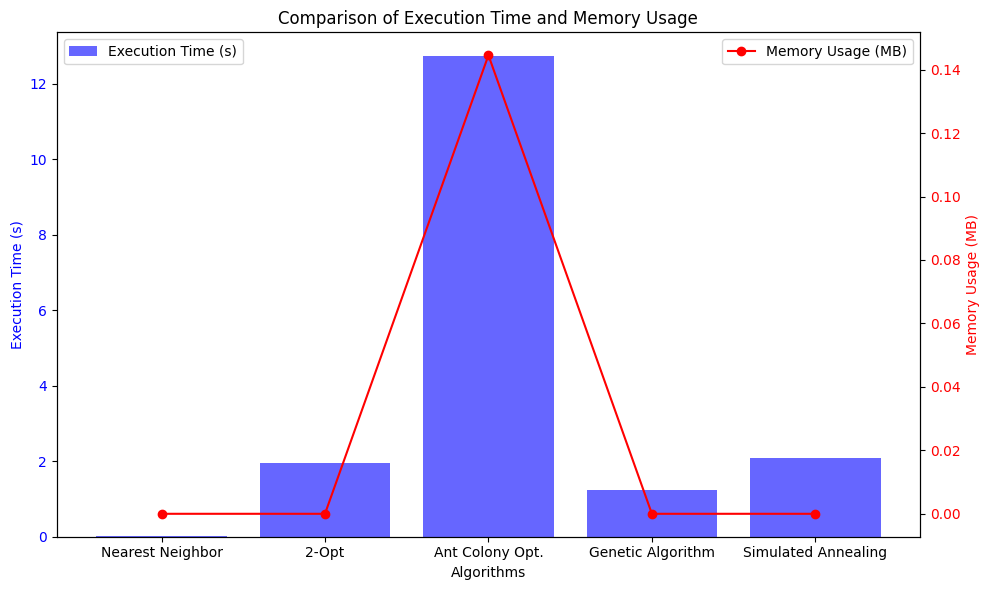

In [56]:
import matplotlib.pyplot as plt

# Extract data for plotting
algorithm_names = list(results.keys())
execution_times = [results[algo]['time'] for algo in algorithm_names]
memory_usages = [results[algo]['memory'] for algo in algorithm_names]

# Create a figure with two subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot execution times
ax1.bar(algorithm_names, execution_times, color='b', alpha=0.6, label='Execution Time (s)')
ax1.set_xlabel('Algorithms')
ax1.set_ylabel('Execution Time (s)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Comparison of Execution Time and Memory Usage')

# Create a second y-axis for memory usage
ax2 = ax1.twinx()
ax2.plot(algorithm_names, memory_usages, color='r', marker='o', label='Memory Usage (MB)')
ax2.set_ylabel('Memory Usage (MB)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()